# Title

## Introduction

**Question**: How do age and experience level predict the number of hours played?

## Methods & Results

In [ ]:
library(tidyverse)
library(repr)
library(tidymodels)
install.packages("plotly")
library(plotly)
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [ ]:
# Read players.csv
players <- read_csv("https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz")
players

# Read sessions.csv
sessions <- read_csv("https://drive.google.com/uc?export=download&id=14O91N5OlVkvdGxXNJUj5jIsV5RexhzbB")
sessions

To answer our quesiton of How does age and experience level predict the number of hours played?, we are going to select the variables experience, played hours, and age to create our new data set. 


In [11]:
players_select <- players |>
    select(played_hours, age, experience)

players_select

played_hours,age,experience
<dbl>,<dbl>,<chr>
30.3,9,Pro
3.8,17,Veteran
0.0,17,Veteran
⋮,⋮,⋮
0.0,17,Amateur
2.3,17,Amateur
0.2,91,Pro


In [15]:
players_new <- mutate(players_select, experience_num = as.numeric(as.factor(experience)))
players_new

played_hours,age,experience,experience_num
<dbl>,<dbl>,<chr>,<dbl>
30.3,9,Pro,3
3.8,17,Veteran,5
0.0,17,Veteran,5
⋮,⋮,⋮,⋮
0.0,17,Amateur,1
2.3,17,Amateur,1
0.2,91,Pro,3


Now we're going to plot Age and Experience with respect to played_hours to get a general idea of our plot and to see which prediction method to use. 

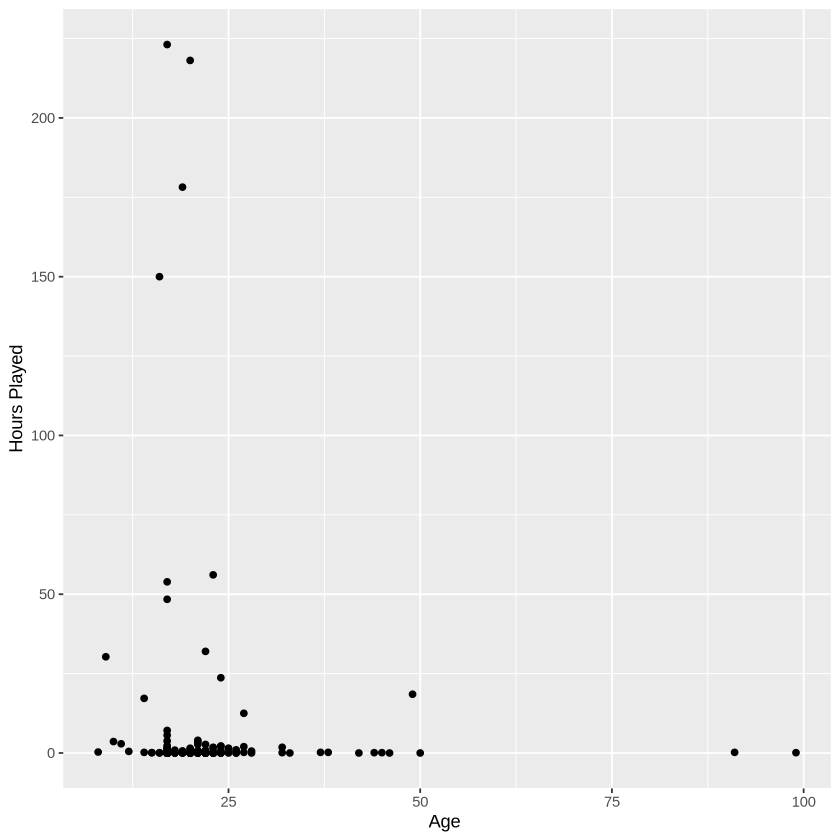

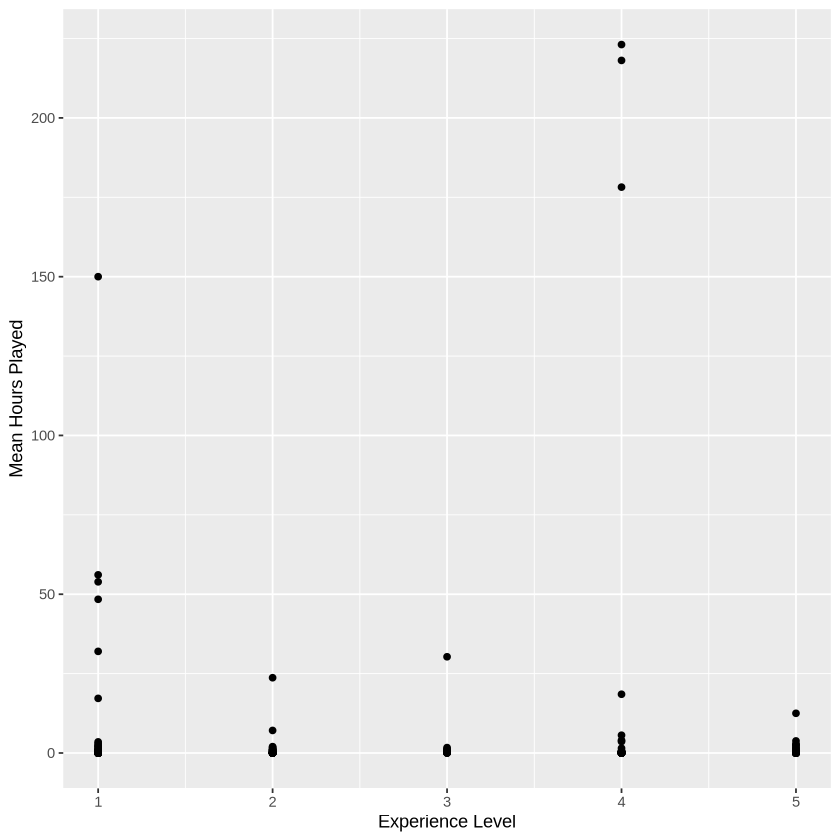

In [16]:
# Age Plot

age_plot <- players_new |>
    ggplot(aes(x = age, y = played_hours)) +
    geom_point() +
    labs(x = "Age ", y = "Hours Played")

age_plot  

# Experience Plot

experience_plot <- players_new |>
    ggplot(aes(x = experience_num, y = played_hours)) +
    geom_point() +
    labs(x = "Experience Level", y = "Mean Hours Played")

experience_plot


We notice that there is no distinct linear relationship within the two graphs. Therefore, we conclude that KNN regression be the best predictive model to use in predicting hours played from the predictive variables "experience" and "age".

We can start building up our knn-regression model. First step is going to be creating our training and testing data.

In [13]:
players_new <- mutate(players_select, experience_num = as.numeric(as.factor(experience)))
players_new

played_hours,age,experience,experience_num
<dbl>,<dbl>,<chr>,<dbl>
30.3,9,Pro,3
3.8,17,Veteran,5
0.0,17,Veteran,5
⋮,⋮,⋮,⋮
0.0,17,Amateur,1
2.3,17,Amateur,1
0.2,91,Pro,3


After converting the experience into numberical values we can start building up our knn-regression model. First step is going to be creating our training and testing data.


In [14]:
#initial split
players_split <- initial_split(players_new, prop = .75, strata = played_hours)

# Training data
players_training <- training(players_split)
#Testing Data
players_testing <- testing(players_split)

players_training
players_testing

ERROR: Error in initial_split(players_new, prop = 0.75, strata = played_hours): could not find function "initial_split"


In [ ]:
set.seed(1234)

players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("regression")

players_recipe <- recipe(played_hours ~ age + experience_num, data = players_new) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

players_vfold <- vfold_cv(players_training, v = 5, strata = played_hours)

players_workflow <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(players_spec)

gridvals <- tibble(neighbors = seq(1,10, by = 1))

players_results <- players_workflow |>
    tune_grid(resamples = players_vfold, grid = gridvals) |>
    collect_metrics()
players_results

In [ ]:
players_min <- players_results |>
    filter(.metric == "rmse") |>
    slice_min(mean, n=1)
players_min

In [ ]:
set.seed(1234) # DO NOT REMOVE

k_min <- players_min |>
          pull(neighbors)

players_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) |>
          set_engine("kknn") |>
          set_mode("regression")

players_best_fit <- workflow() |>
          add_recipe(players_recipe) |>
          add_model(players_best_spec) |>
          fit(data = players_training)

players_summary <- players_best_fit |>
           predict(players_testing) |>
           bind_cols(players_testing) |>
           metrics(truth = played_hours, estimate = .pred)

players_summary

In [2]:
  set.seed(1234) # DO NOT REMOVE

k_min <- players_min |>
          pull(neighbors)

players_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) |>
          set_engine("kknn") |>
          set_mode("regression")

players_best_fit <- workflow() |>
          add_recipe(players_recipe) |>
          add_model(players_best_spec) |>
          fit(data = players_training)

players_summary <- players_best_fit |>
           predict(players_testing) |>
           bind_cols(players_testing) |>
           metrics(truth = played_hours, estimate = .pred)

players_summary

ERROR: Error in pull(players_min, neighbors): could not find function "pull"


## Discussion

In [ ]:
summarize what you found
discuss whether this is what you expected to find?
discuss what impact could such findings have?
discuss what future questions could this lead to?

## References